In [1]:
import numpy as np
import pandas as pd

from importlib import reload

import synthetic.render.generator as gen

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import multiprocessing as mp

import sys
import os
import math
import logging
import time
import galsim
import fitsio as fio

import ngmix

import synthetic.render.render as render
import synthetic.render.icl as icl
import images

In [2]:
catalog_path = '/e/ocean1/users/vargatn/DES/SIM_DATA/SKY_MODEL_EPSILON/res_clust_v2_z0l0/epsilon_clust_v8-z0l0_15000_000.fits'
data = fio.read(catalog_path)
catalog_cluster = data[data['LOC'] == 1]
catalog_field = data[data['LOC'] == 0]

In [3]:
catalog = np.hstack((catalog_cluster, catalog_field))
catalog['G1'] += 0.05
catalog['G1'] += -0.02

In [4]:
df = render.DrawField(5000, catalog, band="i")
df.prepare()
df.make_infodicts()
df.multi_render(100)
df.collate_stamps()

starting xshear calculations in 100 processes


In [5]:
noise_std = 8.36335 / 4
noise = np.random.normal(scale=noise_std, size=(5000, 5000))

Text(0, 0.5, 'Y [pix]')

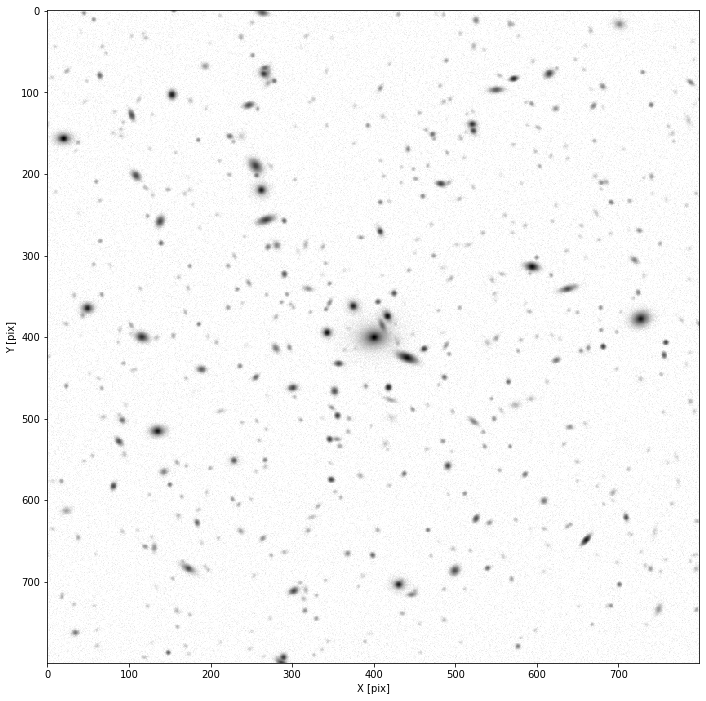

In [6]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
#cc = icl_arrs[2]
cc = df.canvas.array + noise
cc = cc[2100:2900, 2100:2900]
ax.imshow(images.asinh_scale(cc*0.01, 0.12) * 2, cmap=plt.cm.gray_r)
ax.set_xlabel("X [pix]")
ax.set_ylabel("Y [pix]")

In [7]:
arr = df.canvas.array + noise
#arr = arr[2100:2900, 2100:2900]
fio.write("test.fits", arr, clobber=True)

# Extract shear from sextractor results

In [15]:
class Shear(object):
    def __init__(self, canvas, image_epsf, maskmap):
        self.canvas = canvas.copy()
        self.image_epsf = image_epsf
        self.BADVAL = -9999
        self.maskmap = galsim.ImageI(maskmap)
        
    def extract_stamps(self, centers, imasks, size=32):
        half_size = size // 2
        self.stamps = []
        self.masks = []
        for i in np.arange(len(centers)):
            cen = centers[i]
            bb = galsim.bounds.BoundsI(np.round(cen[0]) - half_size,
                                       np.round(cen[0]) + half_size - 1,
                                       np.round(cen[1]) - half_size,
                                       np.round(cen[1]) + half_size - 1)
            stamp = self.canvas[bb]
#             mask = self.maskmap[bb]
#             mm = (mask.array != 0) & (mask.array != imasks[i])
#             mm = (mask.array != imasks[i])
#             mask.array[mm] = 1
            
#             stamp.array[mm] = 0
            
#             self.masks.append(mask)
            self.stamps.append(stamp)


    def estimate_shear(self, sky_var=0, shear_est="KSB", which="canvas"):
        """
        shear modes = REGAUSS’, ‘LINEAR’, ‘BJ’, or ‘KSB’
        which is raw or canvas, default to canvas
        """
        
#         stamps = self.raw_stamps
#         if which == "canvas":
        stamps = self.stamps
        
        self.logs = []
        self.shears = []
        self.success = []
        self.fluxes = []
        self.shears_error = []
        for i, im in enumerate(stamps):
            try:
                res = galsim.hsm.EstimateShear(im, self.image_epsf, shear_est=shear_est, sky_var=sky_var)
                self.logs.append(res)
                
                tmp = np.array([res.corrected_g1, res.corrected_g2])
                
                self.shears.append(tmp)
                self.fluxes.append(res.moments_amp * (self.drawer.pixel_scale)**2)
                self.shears_error.append(res.corrected_shape_err)
                self.success.append(True)
#                 print("here")
            except:
                self.logs.append(None)
                self.fluxes.append(None)
                tmp = np.array([self.BADVAL, self.BADVAL])
                self.shears.append(tmp)
                self.shears_error.append(None)
                self.success.append(False)
                
                
               
        self.fluxes = np.array(self.fluxes)
        self.shears = np.array(self.shears)
        self.success = np.array(self.success)
        self.shears_error = np.array(self.shears_error)



In [16]:
cat = fio.read("test.cat.fits")
seg = fio.read("seg.fits")

In [17]:
sel = cat['FLAGS'] == 0

In [18]:
ids = cat[sel]['NUMBER']
cens = np.vstack((cat[sel]['X_IMAGE'], cat[sel]['Y_IMAGE'])).T

In [19]:
sc = Shear(df.canvas, df.image_epsf, seg)
sc.extract_stamps(cens, imasks=ids, size=32)

In [20]:
sc.estimate_shear(sky_var=0.001)

In [22]:
res = galsim.hsm.EstimateShear(sc.stamps[0], sc.image_epsf, shear_est="KSB", sky_var=0.001)


In [29]:
sc.image_epsf

galsim.Image(bounds=galsim.BoundsI(xmin=1, xmax=20, ymin=1, ymax=20), array=
array([[-2.41009504e-11, -1.41534987e-11, -3.03963764e-11,
        -6.89191690e-11, -1.77530185e-10, -1.16924193e-09,
        -7.10470438e-09, -2.80328205e-08, -7.00284204e-08,
        -1.10636954e-07, -1.10540171e-07, -6.98283174e-08,
        -2.78606258e-08, -6.97920877e-09, -1.04152231e-09,
        -2.18415060e-11,  9.28856506e-11,  1.03056917e-10,
         7.49632231e-11,  2.26680237e-11],
       [-3.57063407e-11, -6.00719682e-11, -1.06386941e-10,
        -1.45497461e-10, -3.69356316e-11,  1.06837705e-09,
         7.39106731e-09,  2.96499163e-08,  7.44898969e-08,
         1.18068883e-07,  1.18267600e-07,  7.49281099e-08,
         3.00759417e-08,  7.72374431e-09,  1.35479439e-09,
         2.44804538e-10,  1.21542623e-10,  1.03037752e-10,
         5.00943280e-11, -2.34730863e-11],
       [-7.89393551e-11, -1.29141628e-10, -1.81709411e-10,
        -2.18748131e-10, -1.72312331e-10,  3.06663750e-10,
         2.

In [28]:
sc.stamps[0]

galsim.Image(bounds=galsim.BoundsI(xmin=2495, xmax=2526, ymin=207, ymax=238), array=
array([[-1.7869739e-06, -1.5407923e-06, -1.0113644e-06, ...,
        -1.6523269e-06, -1.4889519e-06, -1.0301109e-06],
       [-1.5602794e-06, -1.1032981e-06, -3.2083386e-07, ...,
        -1.4400368e-06, -1.5829745e-06, -1.3155329e-06],
       [-1.1728323e-06, -5.6470782e-07,  2.8736542e-07, ...,
        -9.0432394e-07, -1.4062198e-06, -1.4194281e-06],
       ...,
       [-9.1768902e-07, -1.2259267e-05,  1.6710537e-05, ...,
         4.0596113e+00,  2.4521668e+00,  1.4443477e+00],
       [ 2.8185485e-05, -6.9070716e-06,  3.9528950e-05, ...,
         4.6392212e+00,  2.7486067e+00,  1.6112858e+00],
       [ 1.1154632e-04,  3.1108764e-05,  7.1832888e-05, ...,
         4.9940453e+00,  2.9265997e+00,  1.7120476e+00]], dtype=float32), wcs=galsim.PixelScale(0.264))

In [27]:
res

galsim.hsm.ShapeData(image_bounds=galsim.BoundsI(xmin=2495, xmax=2526, ymin=207, ymax=238), moments_status=0, observed_shape=galsim.Shear((-0.019783102426258664+0.012455265802073689j)), moments_sigma=1.8037066459655762, moments_amp=1626.516357421875, moments_rho4=2.0561140542345724, moments_n_iter=18, correction_status=0, corrected_g1=-0.06811194866895676, corrected_g2=0.043233226984739304, meas_type='g', corrected_shape_err=0.0003768512688111514, correction_method='KSB', resolution_factor=0.32986971735954285, psf_sigma=1.4765410423278809, psf_shape=galsim.Shear((-3.240654855574121e-09+1.7542138852633116e-09j)))

In [21]:
sc.shears

array([[-6.81119487e-02,  4.32332270e-02],
       [-9.99900000e+03, -9.99900000e+03],
       [-9.02731493e-02,  2.26792172e-02],
       ...,
       [-9.99900000e+03, -9.99900000e+03],
       [-5.54788783e-02,  5.16873002e-02],
       [-9.99900000e+03, -9.99900000e+03]])

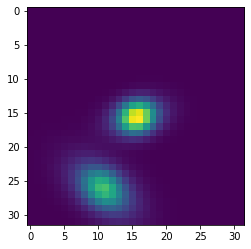

In [248]:
plt.imshow(sc.stamps[1].array)

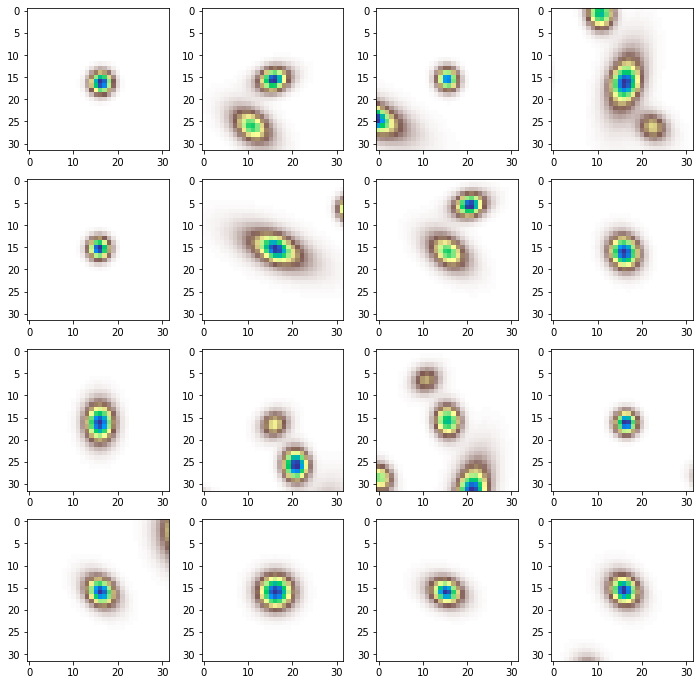

In [249]:
fig, axarr = plt.subplots(4, 4, figsize=(12, 12))

for i, ax in enumerate(axarr.flatten()):
    cc = sc.stamps[i].array
    ax.imshow(images.asinh_scale(cc*0.01, 0.12) * 2, cmap=plt.cm.terrain_r,
              norm=mpl.colors.Normalize())

#     ax.imshow()
fig.savefig("postage_stamps_blending_01.png", bbox_inches='tight')

In [250]:
np.sqrt(cat['X2_IMAGE'] + cat['Y2_IMAGE'])* 3

array([ 8.02520301, 10.03672817,  5.54002591, ...,  6.7902693 ,
        5.71261367,  4.96477023])

Text(0, 0.5, 'Y [pix]')

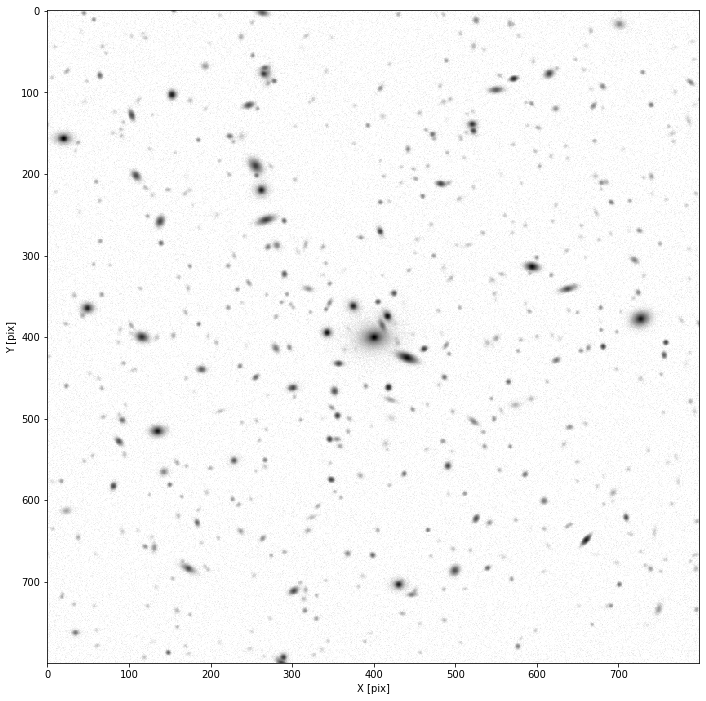

In [251]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
# cc = df.canvas.array# + noise

ax.imshow(images.asinh_scale(arr[2100:2900, 2100:2900]*0.01, 0.12) * 2, cmap=plt.cm.gray_r)
# ax.scatter(cat['X_IMAGE'], cat['Y_IMAGE'])
# ax.set_xlim(0, 799)
# ax.set_ylim(0, 799)
ax.set_xlabel("X [pix]")
ax.set_ylabel("Y [pix]")